# Analysing the 1D shock tube test

In [83]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import h5py
import matplotlib.pyplot as plt
import unyt as u

import richio
richio.plots.use_nice_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import warnings

def _get_at_x(snap,
           quantity, 
           x, 
           xeps=0.05,
           qeps=1e-2):
    """
    Get quantity at x=indices, with coordinate error within xeps and quantity
    error within qeps.
    """
    try:
        indices = np.abs(snap.x - x * snap.x.units) <= xeps * snap.x.units
    except:
        indices = np.abs(snap.x - x) <= xeps * snap.x.units
    qxs = quantity[indices]

    qerr = (np.max(qxs) - np.min(qxs)) / np.min(qxs)
    if qerr > qeps: # percentage error
        warnings.warn(f"Error is {qrr}.")
    
    return np.mean(qxs)

In [85]:
snap_dir = '/home/hey4/rich_tde/data/raw/ShockTubeN1e3IdealGas'
!ls $snap_dir

snap_0.h5     snap_200.vtu  snap_500.h5   snap_700.vtu	snap_final.h5
snap_0.vtu    snap_300.h5   snap_500.vtu  snap_800.h5	snap_final.vtu
snap_100.h5   snap_300.vtu  snap_600.h5   snap_800.vtu
snap_100.vtu  snap_400.h5   snap_600.vtu  snap_900.h5
snap_200.h5   snap_400.vtu  snap_700.h5   snap_900.vtu


In [86]:
snap = richio.load(os.path.join(snap_dir, 'snap_500.h5')) # 900

In [87]:
snap.info()

                                     RICH SNAPSHOT INFORMATION                                      

Snapshot Details                        
----------------------------------------------------------------------------------------------------
  Path                      : /home/hey4/rich_tde/data/raw/ShockTubeN1e3IdealGas/snap_500.h5
  Snapshot Number           : 500
  Time                      : [1.03159934] code_time
  Box size                  : [-10.    -0.01  -0.01  10.     0.01   0.01] code_length
  Cycle                     : [500.] dimensionless
  Number of Ranks           : 1

Available Fields                         [Unit System: RICH]
----------------------------------------------------------------------------------------------------
Field           Unit                                     Aliases
----------------------------------------------------------------------------------------------------
Box             code_length                              box_size, box, boxsiz

/zfsstore/user/hey4/rich_tde/richio/units.py:116: UserWarning: 'Eg_0' is in the data output but not used in the simulation.
  warnings.warn(f"'{key}' is in the data output but not used in the simulation.")


In [88]:
snap.time

unyt_array([1.03159934], 'code_time')

## The rho v P profiles

In [89]:
from rs import RiemannSolver
# Left State
rho_L = 1.0
vx_L = 0.0
P_L = 1.0

# Right State
rho_R = 0.125
vx_R = 0.0
P_R = 0.1

# ideal gas gamma
gamma = 5/3

# time
t = snap.time.value

# Riemann Solver
rs = RiemannSolver(rho_L, vx_L, P_L, rho_R, vx_R, P_R, gamma, t)
x, rho, vx, P = rs.solve()

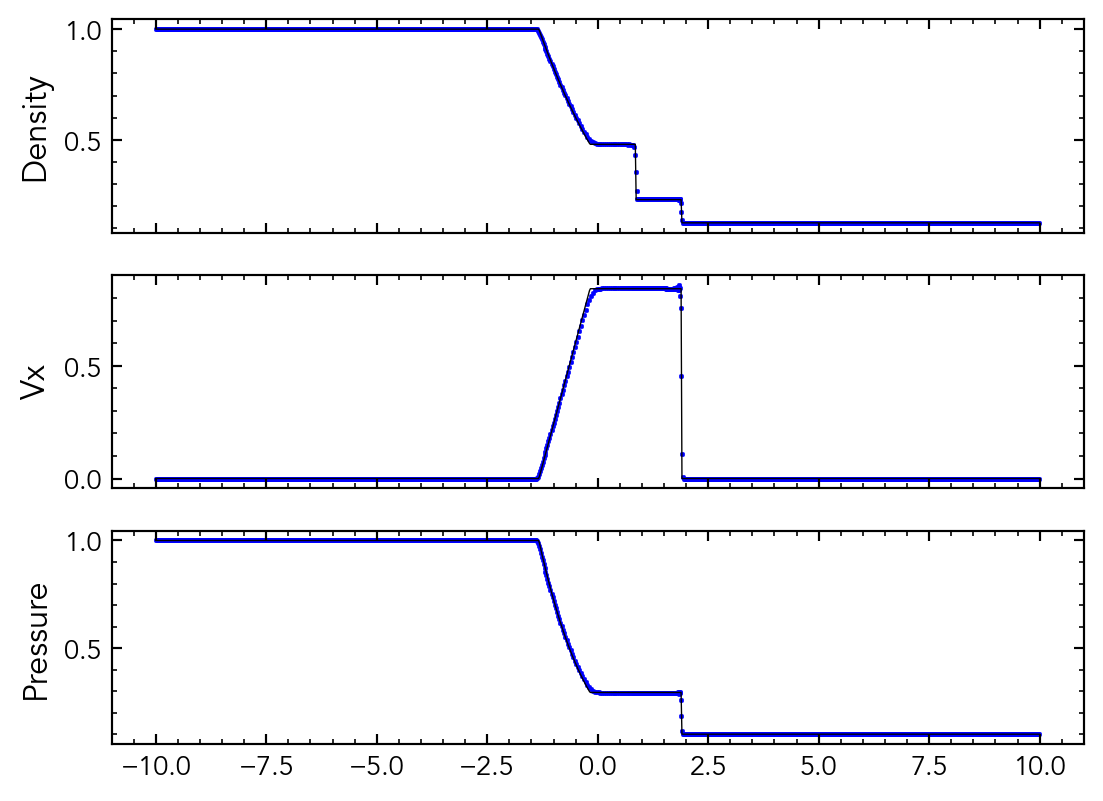

In [90]:
fig, ax = plt.subplots(3, 1, sharex=True)

ax[0].plot(x, rho, color='k', linewidth=0.5)
ax[0].scatter(snap.x, snap.density, marker=',', color='b', s=1)
ax[0].set_ylabel('Density')

ax[1].plot(x, vx, color='k', linewidth=0.5)
ax[1].scatter(snap.x, snap.velocity_x, marker=',', color='b', s=1)
ax[1].set_ylabel('Vx')

ax[2].plot(x, P, color='k', linewidth=0.5)
ax[2].scatter(snap.x, snap.P, marker=',', color='b', s=1)
ax[2].set_ylabel('Pressure')

plt.show()

## Dissipation
Sackur–Tetrode equation: entropy of an monatomic ideal gas ($\gamma = 5/3$)
$$
\frac{S}{k_{\rm B} N} = \ln
\left[ \frac{V}{N} \left(\frac{4\pi m}{3h^2}\frac{U}{N}\right)^{3/2}\right]+
{\frac{5}{2}}
$$
Specific entropy expressed in terms of pressure and density
$$
s = \frac{k_B}{m_H} \left\{ \ln\left[m_H^4 \left(\frac{2\pi}{h^2}\right)^{3/2}\frac{P}{\rho^{\gamma}}\right] + \frac{5}{2} \right\}
$$

In [91]:
def dp2s(rho, p):
    """
    Using the Sackur-Tetrode equation to calculate specific entropy of a
    gamma=5/3 ideal gas, given pressure and density.
    """
    gamma = 5/3
    sie = p / (rho * (gamma - 1)) # specific internal energy
    s = 1 / u.mh * u.kb * (np.log(u.mh / rho * ((4*np.pi*u.mh**2*sie)/(3*u.h**2))**(3/2)) + 5/2) 
    return s

In [92]:
s = dp2s(snap.rho, snap.P)
s =( s * snap.density / snap.density).in_base('rich')

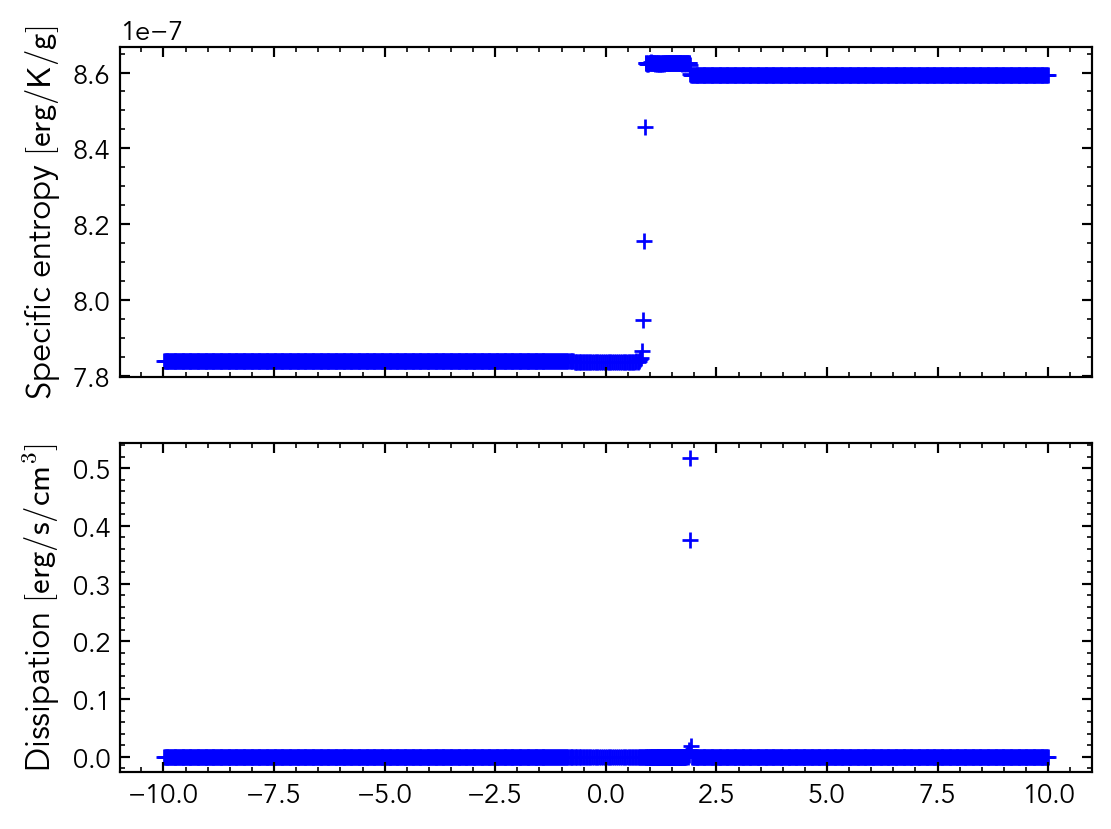

In [93]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].scatter(snap.x, s, marker='+', color='b')
ax[0].set_ylabel(r'Specific entropy $\mathsf{[erg/K/g]}$')

ax[1].scatter(snap.x, snap.dissipation, marker='+', color='b')
ax[1].set_ylabel(r'Dissipation $\mathsf{[erg/s/cm^3]}$')

plt.show()

### Measure shock speed

In [94]:
xs = []
ts = []
for file in os.listdir(snap_dir):
    if file.endswith('h5'):
        _snap = richio.load(os.path.join(snap_dir, file))
        i_shockfront = np.argmax(_snap.dissipation) # shock front as the maximum of dissipation, good enough for sod shock; be careful in other setups
        x = _snap.x[i_shockfront]
        t = _snap.time[0]

        xs.append(x)
        ts.append(t)

xs = u.unyt_array(xs)
ts = u.unyt_array(ts)

/zfsstore/user/hey4/rich_tde/richio/data.py:55: UserWarning: No snapshot number found in path: /home/hey4/rich_tde/data/raw/ShockTubeN1e3IdealGas/snap_final.h5
  warnings.warn(f"No snapshot number found in path: {self.path}")


1.8368036631047748 code_length/code_time 0.0034580574616274893 code_length


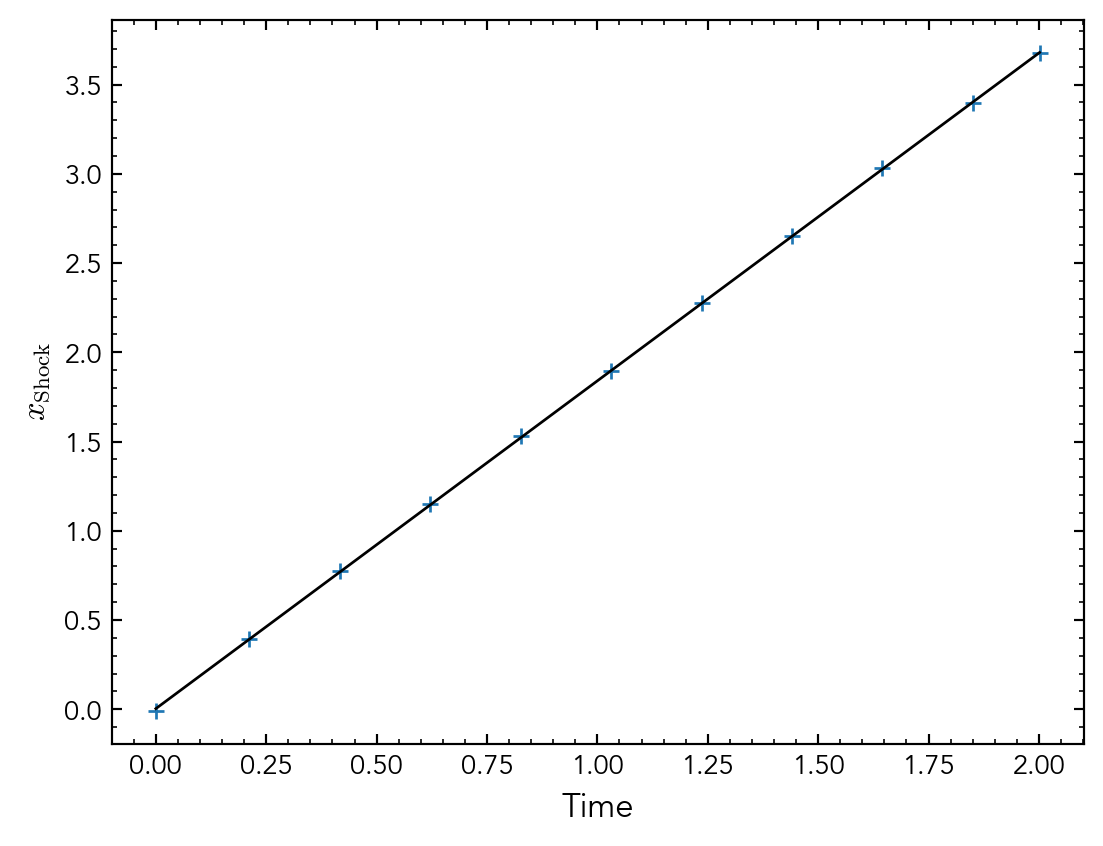

In [95]:
v_shock, b = np.polyfit(ts.value, xs.value, 1)
v_shock *= richio.units.lscale / richio.units.tscale
b *= richio.units.lscale
print(v_shock, b)

plt.scatter(ts, xs, marker='+')
_t = np.linspace(np.min(ts), np.max(ts), 100, True)
plt.plot(_t, _t*v_shock + b, color='k')
plt.xlabel('Time')
plt.ylabel(r'$x_\mathrm{Shock}$')
plt.show()

### Comparison 1: calculate entropy jump
$$
\mathrm{Diss} = T_1 (s_2 - s_1) \rho_1 v_\mathrm{shock} A
$$

In [96]:
# Total dissipation rate (dissipation rate at shock front as well)
diss = snap.dissipation * snap.volume
total_diss = np.sum(diss)
print(f"The total dissipation rate is {total_diss}")

The total dissipation rate is 5.833512396171213e-06 code_length**2*code_mass/code_time**3


In [ ]:
# Get shock front position
i_shock = np.argmax(snap.dissipation)
x_shock = snap.x[i_shock]

# Near the neighbor of the shock front
x1 = x_shock * 1.1  # upstream
x2 = x_shock * 0.9  # downstream
i_shock = (snap.x > x2) & (snap.x < x1)
diss_shock = np.sum(diss[i_shock])
print(f"Dissipation rate across the shock front is {diss_shock}")

Dissipation rate across the shock front is 5.819882760865692e-06 code_length**2*code_mass/code_time**3


In [98]:
# Temperature
T = snap.P / snap.density * u.mh / u.kb

In [99]:
# Cross section
A = (snap.box_size[4] - snap.box_size[1]) * (snap.box_size[5] - snap.box_size[2])
print(f'The cross section is: {A}')

The cross section is: 0.0004 code_length**2


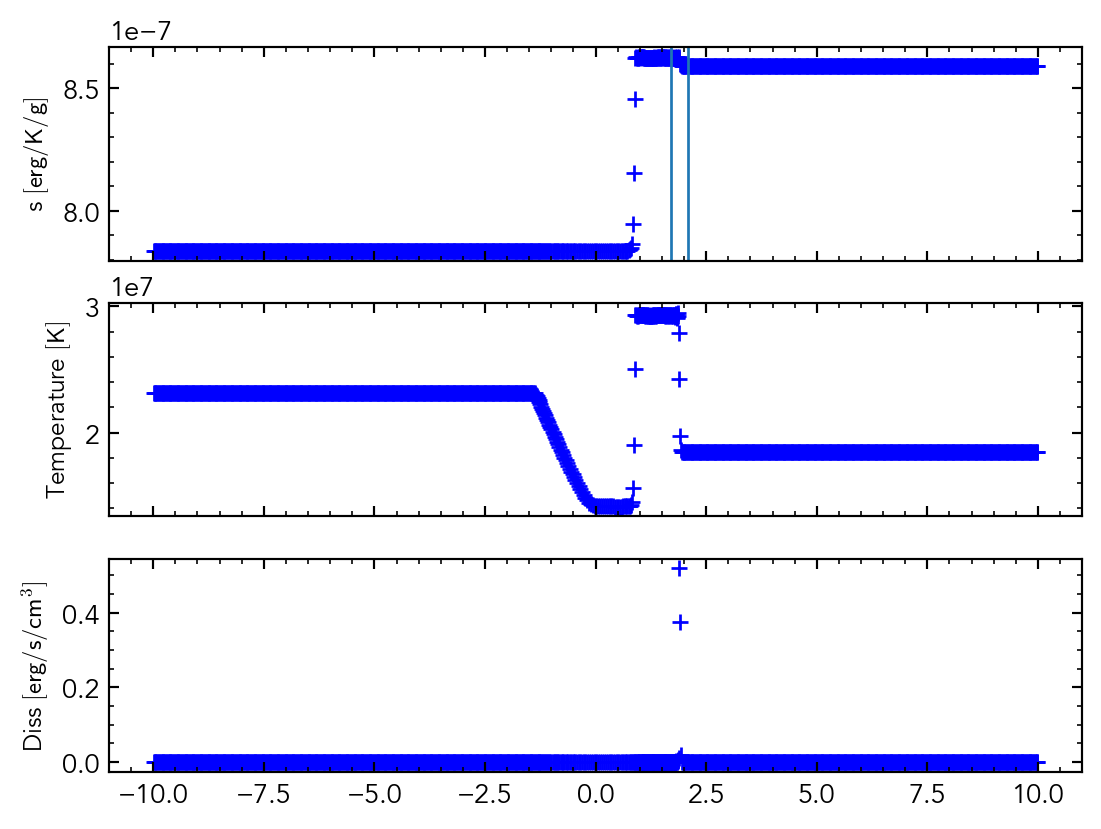

In [100]:
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].scatter(snap.x, s, marker='+', color='b')
ax[0].set_ylabel(r's $\mathsf{[erg/K/g]}$', fontsize=9)

ax[0].axvline(x1.value)
ax[0].axvline(x2.value)

ax[1].scatter(snap.x, T, marker='+', color='b')
ax[1].set_ylabel(r'Temperature $\mathsf{[K]}$', fontsize=9)

ax[2].scatter(snap.x, snap.dissipation, marker='+', color='b')
ax[2].set_ylabel(r'Diss $\mathsf{[erg/s/cm^3]}$', fontsize=9)

plt.show()

In [ ]:
# T_1 (s_2 - s_1)
T1 = _get_at_x(snap, T, x=x1)
T2 = _get_at_x(snap, T, x=x2)
s1 = _get_at_x(snap, s, x=x1)
s2 = _get_at_x(snap, s, x=x2)
rho1 = _get_at_x(snap, snap.rho, x=x1)
diss_sjump = T1 * (s2 - s1) * rho1 * A * v_shock
print(f"Dissipation rate across shock front, as seen from entropy jump {diss_sjump}")

Dissipation rate across shock front, as seen from entropy jump 5.466757415056721e-06 code_length**2*code_mass/code_time**3


In [106]:
diss_shock / diss_sjump

unyt_quantity(1.06459503, '(dimensionless)')

### Comparison 2
$$
\mathrm{Total\,diss\,rate}\,\mathrm{[erg/s]} = u_2 \rho_1 v_\mathrm{shock} A
$$
subscript 1 for upstream, 2 for downstream.

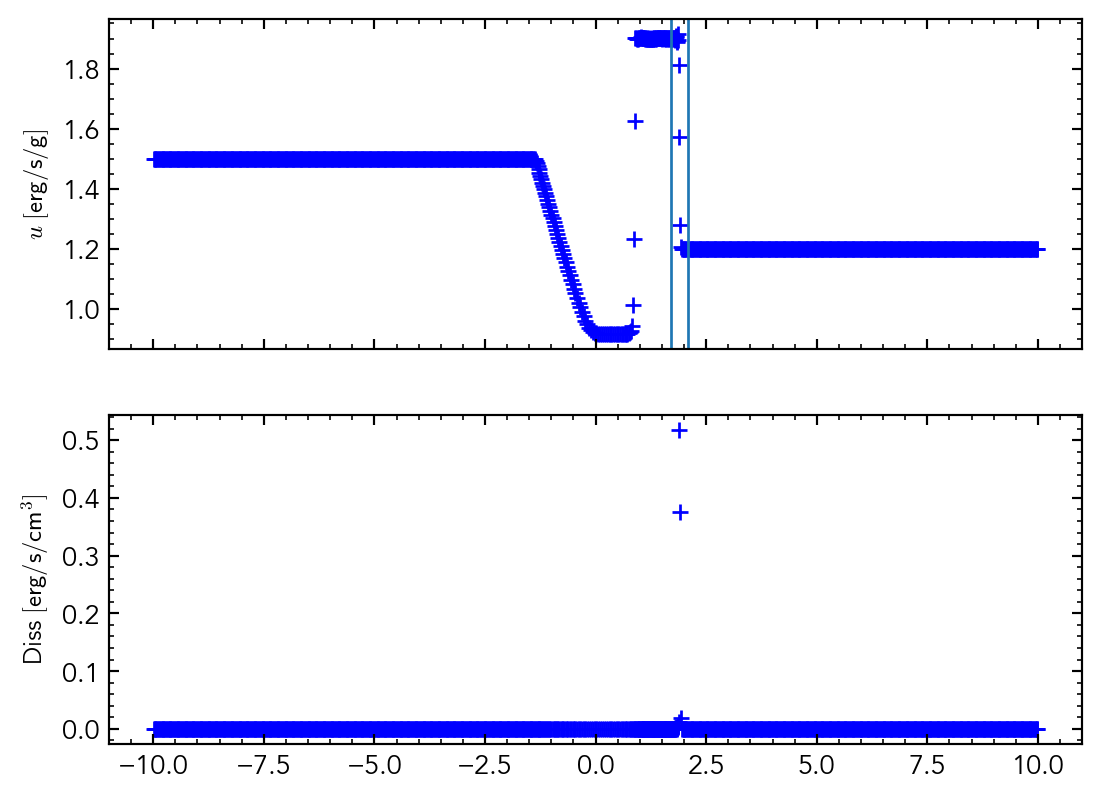

In [103]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].scatter(x=snap.x, y=snap.sie, marker='+', color='b')
ax[0].set_ylabel(r'$u$ $\mathsf{[erg/s/g]}$', fontsize=9)
ax[0].axvline(x1.value)
ax[0].axvline(x2.value)

ax[1].scatter(snap.x, snap.dissipation, marker='+', color='b')
ax[1].set_ylabel(r'Diss $\mathsf{[erg/s/cm^3]}$', fontsize=9)

plt.show()

In [104]:
# Total dissipation rate diagnostic
u2 = _get_at_x(snap, snap.sie, x=x2)
rho1 = _get_at_x(snap, snap.rho, x=x1)
res = u2 * rho1 * v_shock * A
print(res)

0.000174510119026911 code_length**2*code_mass/code_time**3
